In [1]:
#%conda install -c conda-forge yfinance matplotlib tensorflow scikit-learn
#%pip install pandas scikit-learn yfinance matplotlib tensorflow
import json
import numpy as np
import os
import locale
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

# Data Source
import yfinance as yf
import matplotlib.pyplot as plt

from stock_modules.stock_io import (read_tickers_from_excel,
                                    get_histories)

# Figures
from stock_modules.stock_plot import plot_numpy_arr_cols
if not os.path.exists("./figures"):
    os.mkdir("./figures")

2023-11-25 16:04:30.488641: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 16:04:31.023630: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
ENCODING = locale.getpreferredencoding()
DF_PATH = "HEL_12-10-21to08-11-23.csv"
HISTORY_ARRAY_PATH = "./histories_arr.npy"
MODEL_PATH = "./model.h5"
SELECTED_TICKERS_PATH = "./TICKERS_TO_FOLLOW.json"
SELECTED_TICKERS = json.load(open(SELECTED_TICKERS_PATH, "r", encoding=ENCODING))
DATAFRAME = pd.read_csv(DF_PATH, encoding=ENCODING)
DATAFRAME.set_index("date", inplace=True)
HAS_TIMEDELTA = "Time Delta" in DATAFRAME.columns
# ind transformation tells the label of each index in the np_arr_test
IND_CONVERSION = {i: ticker for i, ticker in enumerate(DATAFRAME.columns) if ticker in SELECTED_TICKERS}
IND_CONVERSION = {i: ticker for i, ticker in enumerate(IND_CONVERSION.values())}
print("Selected tickers: \n", SELECTED_TICKERS)
print("Dataframe columns: \n", DATAFRAME.columns)
print("Dataframe shape: ", DATAFRAME.shape)
print("Dataframe head: \n", DATAFRAME.head(2))
print(f"Index conversion: \n {IND_CONVERSION}")

Selected tickers: 
 ['ALBBV.HE', 'CGCBV.HE', 'EQV1V.HE', 'KNEBV.HE', 'ORNBV.HE', 'OLVAS.HE', 'DETEC.HE', 'PON1V.HE', 'ORNAV.HE', 'VALMT.HE', 'NESTE.HE', 'HUH1V.HE', 'REG1V.HE', 'VAIAS.HE']
Dataframe columns: 
 Index(['REG1V.HE', 'NESTE.HE', 'ORNBV.HE', 'KNEBV.HE', 'OLVAS.HE', 'HUH1V.HE',
       'DETEC.HE', 'ORNAV.HE', 'CGCBV.HE', 'VAIAS.HE', 'ALBBV.HE', 'VALMT.HE',
       'EQV1V.HE', 'PON1V.HE'],
      dtype='object')
Dataframe shape:  (4389, 14)
Dataframe head: 
                       REG1V.HE   NESTE.HE   ORNBV.HE   KNEBV.HE   OLVAS.HE  \
date                                                                         
2021-10-12 07:00:00  55.950001  41.820000  35.689999  60.220001  53.099998   
2021-10-12 08:00:00  55.799999  41.720001  35.630001  60.419998  53.299999   

                      HUH1V.HE  DETEC.HE   ORNAV.HE   CGCBV.HE   VAIAS.HE  \
date                                                                        
2021-10-12 07:00:00  38.529999      23.0  38.049999  43.139999  

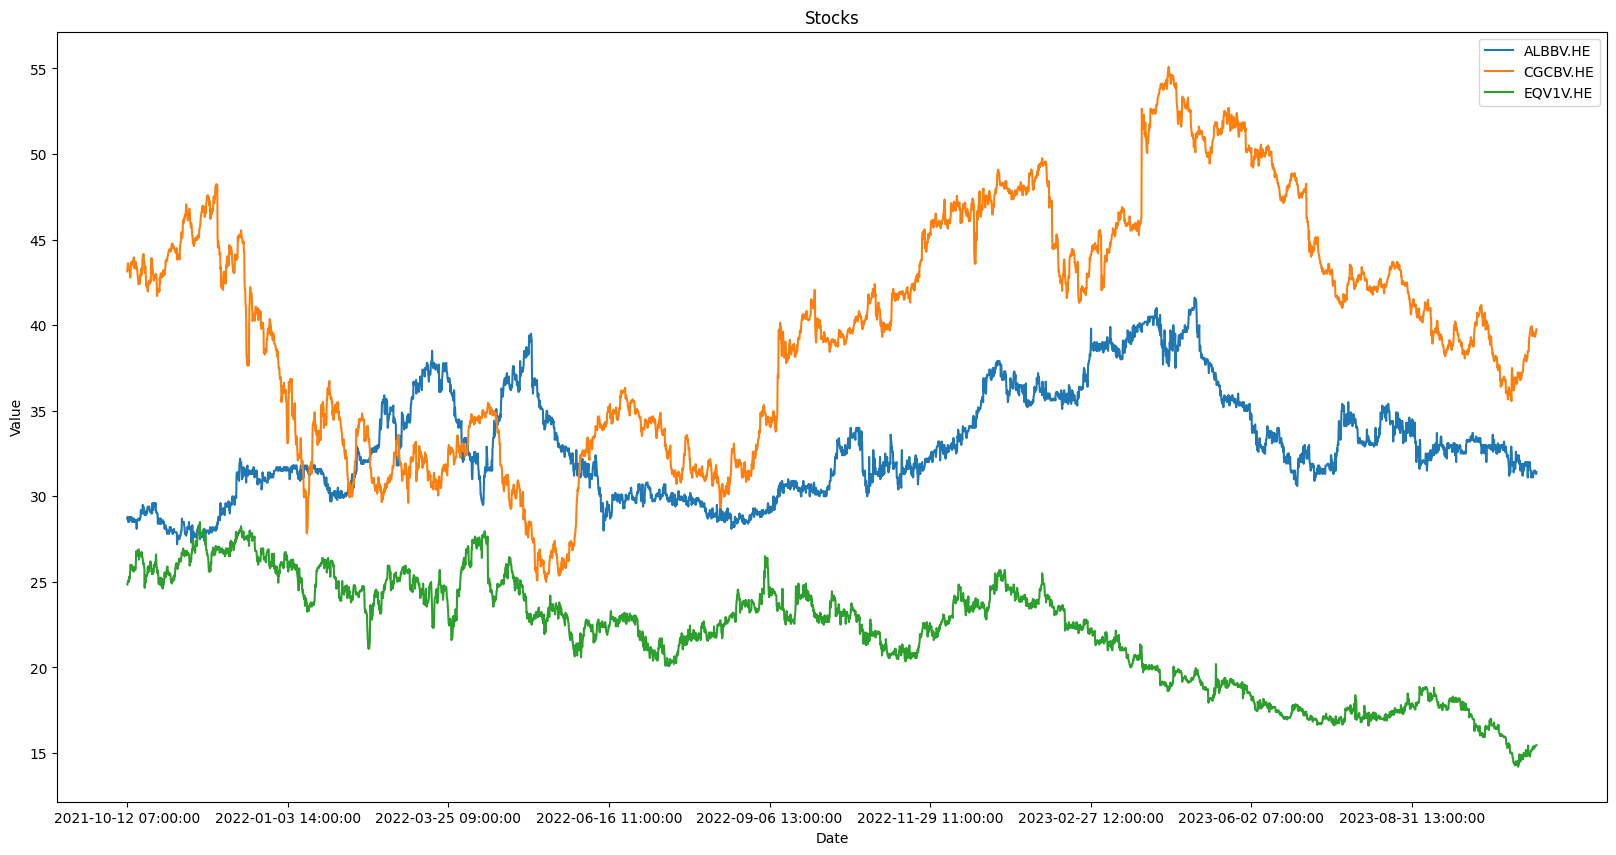

In [3]:
# Show values or not
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Stocks")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
for ticker in SELECTED_TICKERS[:3]:
    ax.plot(DATAFRAME.index, DATAFRAME[ticker], label=ticker)
# Change xticks
ax.set_xticks(DATAFRAME.index[::500])
ax.legend()
plt.show()

In [4]:
# If we are predicting the next price, we just minmax scale the data
TEST_FRAC = 0.2
PREDICT_PRICES = False
if PREDICT_PRICES:
    scaler = MinMaxScaler()
    test_begin_idx = int(DATAFRAME.shape[0] * (1 - TEST_FRAC))

    scaler.fit(DATAFRAME.iloc[:test_begin_idx, :])
    transformed_df = pd.DataFrame(scaler.transform(DATAFRAME), columns=DATAFRAME.columns, index=DATAFRAME.index)
    transformed_np_arr = transformed_df.to_numpy()

    def inverse_transform(df):
        if isinstance(df, pd.DataFrame):
            return pd.DataFrame(scaler.inverse_transform(df), columns=df.columns, index=df.index)
        elif isinstance(df, np.ndarray):
            return scaler.inverse_transform(df)
# If we are predicting the up/down, we create a dataframe where we subtract the previous value from the current value
else:
    # Do not diff the Time Delta column
    df = DATAFRAME.copy()
    if HAS_TIMEDELTA:
        td_col = df["Time Delta"]
        df.drop("Time Delta", axis=1, inplace=True)
    transformed_df = df.diff()
    # The first row is NaN, so lets copy the second row there
    transformed_df.iloc[0, :] = transformed_df.iloc[1, :]
    # Add back the Time Delta column
    if HAS_TIMEDELTA:
        transformed_df["Time Delta"] = td_col
        # Make Time Delta the first column
        cols = transformed_df.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        transformed_df = transformed_df[cols]
    transformed_np_arr = transformed_df.to_numpy()

    def inverse_transform(df):
        return df

print("Transformed df: \n", transformed_df.head(2))
print("Transformed df shape: ", transformed_df.shape)

Transformed df: 
                      REG1V.HE  NESTE.HE  ORNBV.HE  KNEBV.HE  OLVAS.HE  \
date                                                                    
2021-10-12 07:00:00 -0.150002 -0.099998 -0.059998  0.199997  0.200001   
2021-10-12 08:00:00 -0.150002 -0.099998 -0.059998  0.199997  0.200001   

                     HUH1V.HE  DETEC.HE  ORNAV.HE  CGCBV.HE  VAIAS.HE  \
date                                                                    
2021-10-12 07:00:00  0.030003       0.0       0.0  0.360001 -0.200001   
2021-10-12 08:00:00  0.030003       0.0       0.0  0.360001 -0.200001   

                     ALBBV.HE  VALMT.HE  EQV1V.HE  PON1V.HE  
date                                                         
2021-10-12 07:00:00  0.099998  0.139999       0.1  0.049999  
2021-10-12 08:00:00  0.099998  0.139999       0.1  0.049999  
Transformed df shape:  (4389, 14)


In [5]:
from stock_modules.stock_transform import (histories_to_array,
                                           create_batch_xy)
MHOURS = 12
OUTPUT_SCALE = (0,1)
# Batch X data into sequences of length MHOURS (from T to T+n), and Y data
# into sequences of length 1 (T+n+1)
X, Y = create_batch_xy(MHOURS, transformed_np_arr, overlap=True, y_updown=True, diff_data=True, output_scale=OUTPUT_SCALE)

X_og = X.copy()
Y_og = Y.copy()

test_sz = int(X.shape[0] * TEST_FRAC)

# Split the data into train and test sets
X_train = X[:-test_sz,:,:]
Y_train = Y[:-test_sz,:]
X_test = X[-test_sz:,:,:]
Y_test = Y[-test_sz:,:]



print(f"Example input output pair: \n {X_train[0]} \n {Y_train[0]}")
print(f"Input shape: {X_train.shape}")
print(f"Output shape: {Y_train.shape}")
# Count the number of up/downs in the training set
print(f"Number of ups in training set: {np.sum(Y_train == OUTPUT_SCALE[1])}")
print(f"Number of downs in training set: {np.sum(Y_train == OUTPUT_SCALE[0])}")



            Batched 'histories_arr' ((4389, 14)) to 'X'
            ((4377, 12, 14)) and 'Y' ((4377, 14))
            
Example input output pair: 
 [[-0.15000153 -0.09999847 -0.05999756  0.19999695  0.20000076  0.03000259
   0.          0.          0.36000061 -0.20000076  0.09999847  0.13999939
   0.10000038  0.04999924]
 [-0.15000153 -0.09999847 -0.05999756  0.19999695  0.20000076  0.03000259
   0.          0.          0.36000061 -0.20000076  0.09999847  0.13999939
   0.10000038  0.04999924]
 [-0.09999847  0.34000015 -0.22999954 -0.21999741 -0.09999847 -0.2100029
   0.          0.          0.11999893 -0.10000229 -0.19999886 -0.19999695
   0.04999924  0.29999924]
 [-0.25       -0.05000305  0.09999847 -0.08000183 -0.29999924 -0.12999725
   0.20000076  0.         -0.13999939 -0.14999771 -0.10000038 -0.11000061
   0.10000038  0.04999924]
 [ 0.54999924 -0.00999832  0.18000031  0.36000061 -0.30000305  0.12999725
   0.         -0.04999924 -0.20000076 -0.04999924  0.20000076  0.07999802
  -0

In [31]:
%load_ext autoreload
%autoreload 2
from stock_modules.stock_ml import create_price_prediction_model, create_updown_prediction_model, create_updown_prediction_model_dense

MODEL_PATH = "./model.h5"
RENEW_MODEL = True
PATIENCE = 20
EPOCHS = 300
BATCH_SIZE = 64

class SkipTDLoss(tf.keras.losses.Loss):
    """ A loss funciton, that calculates the given loss for all columns except the first one (Time Delta)
    """
    def __init__(self, base_loss_fun, **kwargs):
        super().__init__(**kwargs)
        self.base_loss_fun = base_loss_fun
    
    def call(self, y_true, y_pred):
        # Skip first column
        return self.base_loss_fun(y_true[:,1:], y_pred[:,1:])

LOSS_FUN = tf.keras.losses.BinaryCrossentropy()

# Fit model by showing it the data from the last MHOURS hours, and
# predicting the next hour
if os.path.exists(MODEL_PATH) and not RENEW_MODEL:
    if HAS_TIMEDELTA:
        skip_td_loss = SkipTDLoss(LOSS_FUN)
        model = tf.keras.models.load_model(MODEL_PATH, custom_objects={"SkipTDLoss": skip_td_loss})
    else:
        model = tf.keras.models.load_model(MODEL_PATH)
else:
    model = create_updown_prediction_model(MHOURS, transformed_np_arr.shape[1], output_scale=OUTPUT_SCALE)
    # Show example output of model
    print(f"Example model output: \n {model.predict(X_train[0:1,:,:])}")
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss=LOSS_FUN, optimizer=opt, metrics=["accuracy", "mae"])
    if HAS_TIMEDELTA:
        model.compile(loss=SkipTDLoss(LOSS_FUN), optimizer="adam", metrics=["accuracy", "mae"])
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=PATIENCE,
        restore_best_weights=True
    )
    model.fit(X_train, Y_train,
            epochs=EPOCHS, batch_size=BATCH_SIZE,
            validation_data=(X_test, Y_test), verbose=1,
            callbacks=[early_stop], shuffle=True)
    model.save(MODEL_PATH)
# Show true values and predictions
Y_pred = model.predict(X_test)
if HAS_TIMEDELTA:
    Y_pred = Y_pred[:,1:]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 12, 14)]             0         []                            
                                                                                                  
 batch_normalization_4 (Bat  (None, 12, 14)               56        ['input_5[0][0]']             
 chNormalization)                                                                                 
                                                                                                  
 bidirectional (Bidirection  (None, 12, 256)              146432    ['batch_normalization_4[0][0]'
 al)                                                                ]                             
    

2023-11-25 16:09:23.542582: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "AuthenticAMD" model: "241" frequency: 3792 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 524288 l3_cache_size: 33554432 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-11-25 16:09:26.538585: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "AuthenticAMD" model: "241" frequency: 3792 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SS

55/55 [==============================] - 5s 26ms/step - loss: 5.9343 - accuracy: 0.0306 - mae: 0.4995 - val_loss: 5.5283 - val_accuracy: 0.0217 - val_mae: 0.4990
Epoch 2/300
 1/55 [..............................] - ETA: 0s - loss: 5.5272 - accuracy: 0.0312 - mae: 0.4982

2023-11-25 16:09:28.219097: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "AuthenticAMD" model: "241" frequency: 3792 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 524288 l3_cache_size: 33554432 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


55/55 [==============================] - 1s 12ms/step - loss: 5.1770 - accuracy: 0.0263 - mae: 0.4983 - val_loss: 4.8248 - val_accuracy: 0.0046 - val_mae: 0.4971
Epoch 3/300
55/55 [==============================] - 1s 12ms/step - loss: 4.5219 - accuracy: 0.0171 - mae: 0.4964 - val_loss: 4.2160 - val_accuracy: 0.0011 - val_mae: 0.4943
Epoch 4/300
55/55 [==============================] - 1s 12ms/step - loss: 3.9560 - accuracy: 0.0023 - mae: 0.4942 - val_loss: 3.6904 - val_accuracy: 0.0011 - val_mae: 0.4923
Epoch 5/300
55/55 [==============================] - 1s 12ms/step - loss: 3.4669 - accuracy: 0.0014 - mae: 0.4929 - val_loss: 3.2366 - val_accuracy: 0.0011 - val_mae: 0.4907
Epoch 6/300
55/55 [==============================] - 1s 12ms/step - loss: 3.0449 - accuracy: 5.7110e-04 - mae: 0.4920 - val_loss: 2.8452 - val_accuracy: 0.0011 - val_mae: 0.4894
Epoch 7/300
55/55 [==============================] - 1s 12ms/step - loss: 2.6811 - accuracy: 0.0014 - mae: 0.4913 - val_loss: 2.5083 - val

/home/ilmari/python/stonk-prediction/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 1s 3ms/step


2023-11-25 16:10:41.964303: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "AuthenticAMD" model: "241" frequency: 3792 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 524288 l3_cache_size: 33554432 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


In [32]:
print("Y_pred: \n", Y_pred)
print("Y_test: \n", Y_test)

# Calculate the accuracy of up-down predictions
# So predict the up/down of each stock, at each time on the test data (Y_pred)
# and compare it to the true values (Y_test)
threshold = 0.5
print(threshold)
for stock_idx in range(Y_pred.shape[1]):
    # Get the up/down predictions for the stock
    updown_pred = Y_pred[:,stock_idx]
    updown_pred = updown_pred > threshold
    # Get the true up/down values for the stock
    updown_true = Y_test[:,stock_idx]
    accuracy = np.sum(updown_pred == updown_true) / updown_pred.shape[0]
    print(f"Accuracy for stock {IND_CONVERSION[stock_idx]}: {accuracy}")

Y_pred: 
 [[0.47688127 0.4717755  0.51301587 ... 0.47892532 0.39820316 0.39809686]
 [0.47111547 0.48151574 0.50486153 ... 0.48616564 0.38348275 0.40094203]
 [0.5402712  0.47928676 0.49618894 ... 0.53791064 0.5266856  0.45525587]
 ...
 [0.4599062  0.4776005  0.5087557  ... 0.4772813  0.38990313 0.39492038]
 [0.47442418 0.4753834  0.511428   ... 0.48135617 0.39317137 0.39974627]
 [0.4754459  0.4817025  0.5020836  ... 0.48894465 0.3830413  0.40277863]]
Y_test: 
 [[1. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 1. 0. 1.]
 [0. 1. 0. ... 1. 0. 0.]
 ...
 [0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 0. 1.]]
0.5
Accuracy for stock REG1V.HE: 0.5165714285714286
Accuracy for stock NESTE.HE: 0.5108571428571429
Accuracy for stock ORNBV.HE: 0.512
Accuracy for stock KNEBV.HE: 0.5542857142857143
Accuracy for stock OLVAS.HE: 0.6091428571428571
Accuracy for stock HUH1V.HE: 0.5211428571428571
Accuracy for stock DETEC.HE: 0.68
Accuracy for stock ORNAV.HE: 0.5908571428571429
Accuracy for stock 

In [33]:

from invest_strategies import (calculate_optimal_invest_strategy,
                               calculate_profit_on_invest_strategy,
                               strategy_mask_from_price_model,
                               strategy_mask_from_updown_model)

# Calculate profit by optimal strategy (theoretical) vs using model to predict
test_sz = int(DATAFRAME.shape[0] * TEST_FRAC)
df_test = DATAFRAME.iloc[-test_sz:,:].copy()
if HAS_TIMEDELTA:
    df_test.drop("Time Delta", axis=1, inplace=True)
np_arr_test = df_test.to_numpy()
print("np_arr_test data shape: ", np_arr_test.shape)

optimal_trading_mask = calculate_optimal_invest_strategy(np_arr_test)
print(f"Optimal mask 4th stock: \n {optimal_trading_mask[:,2]}")
profit_optimal = calculate_profit_on_invest_strategy(np_arr_test, optimal_trading_mask)
print(f"Optimal strategy matrix shape: {optimal_trading_mask.shape}")
print(f"Profit by optimal strategy on test data: {profit_optimal}")

# To calculate the mask for the model, we need to give the data in the same format as it was trained in
transformed_df_test = transformed_df.iloc[-test_sz:,:]
transformed_np_arr_test = transformed_df_test.to_numpy()
print("transformed_np_arr_test data shape: ", transformed_np_arr_test.shape)
prediction_trading_mask = strategy_mask_from_updown_model(transformed_np_arr_test, MHOURS, model, output_scale=OUTPUT_SCALE)

if HAS_TIMEDELTA:
    prediction_trading_mask = prediction_trading_mask[:,1:]

print(f"Prediction mask 2th stock: \n {prediction_trading_mask[:,2]}")
profit_pred_model = calculate_profit_on_invest_strategy(np_arr_test, prediction_trading_mask)
print(f"Prediction strategy matrix shape: {prediction_trading_mask.shape}")
print(f"Profit by predicting the next hour using the model: {profit_pred_model}")

np_arr_test data shape:  (877, 14)
Optimal mask 4th stock: 
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0


            Batched 'histories_arr' ((877, 14)) to 'X'
            ((865, 12, 14)) and 'Y' ((865, 14))
            
28/28 [==============================] - 0s 3ms/step
Prediction mask 2th stock: 
 [ 0. -1.  1.  0.  0.  0.  0. -1.  0.  1.  0.  0. -1.  1.  0. -1.  1. -1.
  1. -1.  0.  0.  0.  0.  1.  0. -1.  0.  0.  0.  0.  0.  1.  0. -1.  1.
  0.  0.  0. -1.  0.  1.  0.  0. -1.  0.  1. -1.  1. -1.  0.  1. -1.  0.
  1.  0.  0. -1.  0.  0.  0.  0.  1.  0. -1.  1.  0. -1.  0.  0.  0.  0.
  1.  0.  0.  0.  0. -1.  1.  0.  0. -1.  0.  1. -1.  1.  0.  0.  0. -1.
  0.  0.  1. -1.  1.  0. -1.  0.  1.  0.  0.  0.  0.  0. -1.  1.  0. -1.
  1. -1.  1. -1.  1. -1.  1.  0.  0.  0.  0.  0.  0. -1.  1. -1.  0.  0.
  1. -1.  1.  0.  0. -1.  0.  0.  0.  1. -1.  0.  1. -1.  1. -1.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  1. -1.  1.  0.  0.  0.  0.
  0. -1.  0.  0.  0.  0.  0.  0.  1. -1.  0.  1.  0. -1.  1.  0. -1.  0.
  0.  0.  0.  0.  0.  0.  0.  1. -1.  1.  0. -1.  1. -1.  1.  0.  0. -1


            Batched 'histories_arr' ((877, 14)) to 'X'
            ((865, 12, 14)) and 'Y' ((865, 14))
            



            Profit on optimal strategy:
            152.34999465942383
            

            Batched 'histories_arr' ((877, 14)) to 'X'
            ((865, 12, 14)) and 'Y' ((865, 14))
            

            Batched 'histories_arr' ((877, 14)) to 'X'
            ((865, 12, 14)) and 'Y' ((865, 14))
            
28/28 [==============================] - 0s 3ms/step
Profit on invest strategy: -5.929967880249023


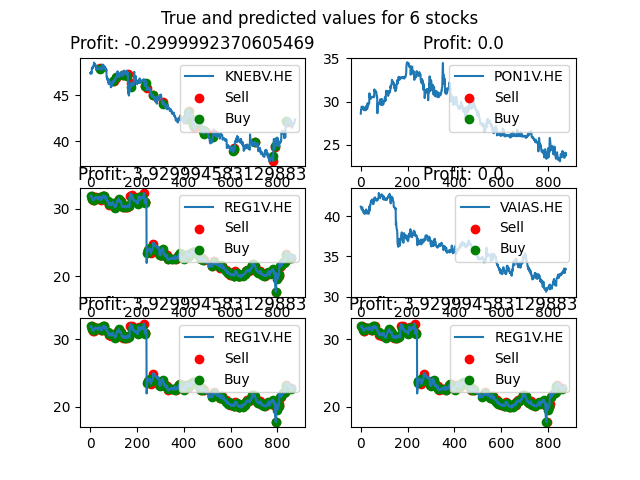

(<Figure size 640x480 with 6 Axes>,
 array([[<Axes: title={'center': 'Profit: -0.2999992370605469'}>,
         <Axes: title={'center': 'Profit: 0.0'}>],
        [<Axes: title={'center': 'Profit: 3.929994583129883'}>,
         <Axes: title={'center': 'Profit: 0.0'}>],
        [<Axes: title={'center': 'Profit: 3.929994583129883'}>,
         <Axes: title={'center': 'Profit: 3.929994583129883'}>]],
       dtype=object))

In [34]:
%matplotlib widget
from stock_modules.stock_plot import plot_strategy_based_on_predictions
plot_strategy_based_on_predictions(np_arr_test, transformed_np_arr_test, model, MHOURS, output_scale=OUTPUT_SCALE,ind_conversion=IND_CONVERSION)

X_start shape: (12, 14)
Y_preds_recurse shape: (1, 14)
Y_true_recurse shape: (50, 14)
Y_preds_recurse shape: (50, 14)
Mean absolute error of hourly predictions: [0.49829271 0.49844538 0.49945438 0.49675258 0.48145311 0.49897101
 0.43095042 0.49006589 0.49865716 0.48937615 0.41944968 0.4978632
 0.47768464 0.47039805]
Mean absolute error of recursive predictions:
        [0.49011392 0.51246165 0.51008814 0.49942275 0.48167099 0.50744352
 0.44868373 0.48728841 0.52955639 0.49067443 0.41803151 0.50674038
 0.50992082 0.46727497]
Average hourly change: [0.50343249 0.48169336 0.50457666 0.50686499 0.5228833  0.51029748
 0.51144165 0.5194508  0.51372998 0.51487414 0.54576659 0.51487414
 0.52173913 0.5       ]


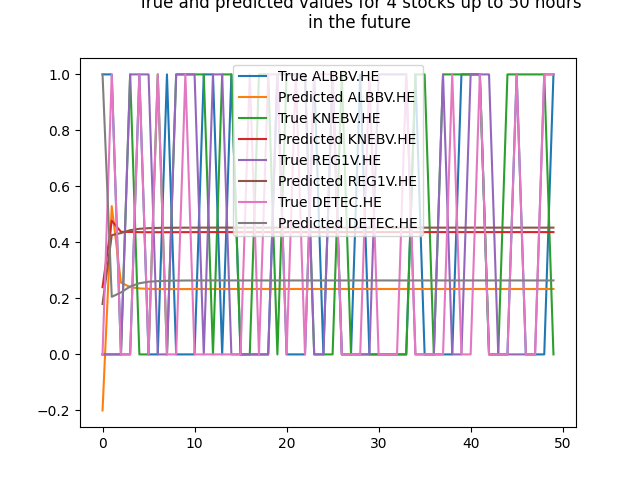

In [35]:
RECURSE_TO = 50
# Start from the RECURSE_TO latest hour, predict the next hour, and then
# use the predicted hour to predict the next hour, and so on
X_start = X_test[-RECURSE_TO,:,:]
print(f"X_start shape: {X_start.shape}")
Y_preds_recurse = X_start[-1,:].reshape(1,X.shape[2])
Y_true_recurse = Y_test[-RECURSE_TO:,:]
print(f"Y_preds_recurse shape: {Y_preds_recurse.shape}")
print(f"Y_true_recurse shape: {Y_true_recurse.shape}")

for i in range(RECURSE_TO - 1):
    Y_pred_ = model.predict(X_start.reshape(1,MHOURS,X.shape[2]), verbose=0)
    Y_preds_recurse = np.concatenate([Y_preds_recurse, Y_pred_], axis=0)
    # Shift X_start one hour forward
    X_start = np.concatenate([X_start[1:,:], Y_pred_], axis=0)
Y_preds_recurse = np.array(Y_preds_recurse).squeeze()
print(f"Y_preds_recurse shape: {Y_preds_recurse.shape}")

# Invert scaling of predictions
Y_preds_recurse = inverse_transform(Y_preds_recurse)
Y_true_recurse = inverse_transform(Y_true_recurse)

# Select 5 stocks with the smallest mae to plot
mae_recursive_preds = np.mean(np.abs(Y_preds_recurse - Y_true_recurse),
                                axis=0)
stock_idxs = np.argsort(mae_recursive_preds)[:10]
stock_idxs = np.random.choice(stock_idxs, 4, replace=False)

fig, ax = plt.subplots()
for stock_idx in stock_idxs:
    ax.plot(Y_true_recurse[:,stock_idx],
            label=f"True {IND_CONVERSION[stock_idx]}")
    ax.plot(Y_preds_recurse[:,stock_idx],
            label=f"Predicted {IND_CONVERSION[stock_idx]}")
ax.legend()
ax.set_title(f"""
            True and predicted values for 4 stocks up to {RECURSE_TO} hours
            in the future
            """)
plt.savefig("./figures/recursive_prediction.png")

# Calculate the error of the predictions
mae_hourly_preds = np.mean(np.abs(Y_pred - Y_test), axis=0)
print(f"Mean absolute error of hourly predictions: {mae_hourly_preds}")
print(f"""Mean absolute error of recursive predictions:
        {mae_recursive_preds}""")

# As a baseline, calculate how much the price changes per hour on the test
# data
average_hourly_change = np.mean(np.abs(np.diff(Y_test, axis=0)), axis=0)
print(f"Average hourly change: {average_hourly_change}")